# VAMPNets
https://deeptime-ml.github.io/latest/notebooks/examples/ala2-example.html

In [14]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import mdshare  # for trajectory data

from tqdm.notebook import tqdm  # progress bar

In [15]:
# Use GPU if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU 사용
    print("Using Apple MPS (Metal) GPU")
else:
    device = torch.device("cpu")
torch.set_num_threads(12)

print(f"Using device {device}")

Using device cuda


In [16]:
# Obtain the data via mdshare
# Alanine Dipeptide
ala_coords_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-heavy-atom-positions.npz", working_directory="data"
)
with np.load(ala_coords_file) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

# Dihedral : backbone angle, phi & psi
dihedral_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz", working_directory="data"
)
with np.load(dihedral_file) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]                   # dihedral has AD protein backbone

Data is list, with len =3

data[0], [1], [2] includes three independent simulations.
(https://markovmodel.github.io/mdshare/ALA2/#alanine-dipeptide)

In [17]:
d0 = data[0]
d1 = data[1]
d2 = data[2]


print(f"Shape of data[0]: {d0.shape}")
print(f"{d0.shape[0]} is number of frames")
print(f"{d0.shape[1]} is 3* 10, 3Dimensional, 10 heavy atoms")


Shape of data[0]: (250000, 30)
250000 is number of frames
30 is 3* 10, 3Dimensional, 10 heavy atoms


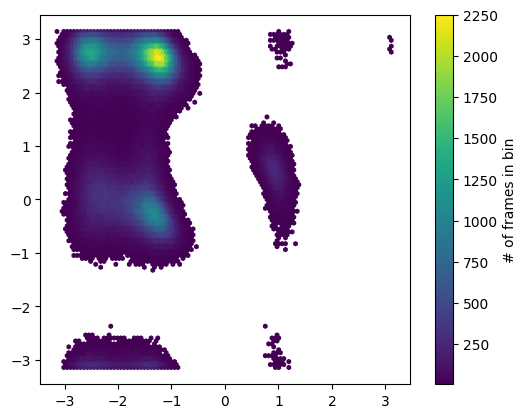

In [18]:
fig, ax = plt.subplots(1, 1)
hb = ax.hexbin(*np.concatenate(dihedral).T, mincnt=5) # Draw Heatmap(hexbin)
ax.set_aspect('equal') # Ratio of x, y axis are equal
cb = fig.colorbar(hb, ax=ax)
cb.set_label('# of frames in bin')

X, Y axis are ~3.14- 3.14
Because angles are in radian

Define the dataset. lagtime tau = 1

In [19]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

dataset = TrajectoriesDataset.from_numpy(1, data) # Init dataset with Heavy atom position data

In [20]:
n_val = int(len(dataset)*.1)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

In [21]:
# Set VAMPNet lobes(Neural network)
# Use PyTorch sequential model way
lobe = nn.Sequential(
    nn.BatchNorm1d(data[0].shape[1]),               # Input dimension(data[0].shape[1]) is decided by number of features.
    nn.Linear(data[0].shape[1], 20), nn.ELU(),      # First hidden layer, ELU is a activation function
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 6),                               # Output layer. map to 6 states. We can try 4-10 and pick.
    # Num of Output states: Too many? -> overfit, Too little -> not enough categories
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
)

lobe = lobe.to(device=device)                       # Move model from GPU to CPU
print(lobe)

Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=20, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=20, out_features=20, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=20, out_features=20, bias=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=20, out_features=20, bias=True)
  (10): ELU(alpha=1.0)
  (11): Linear(in_features=20, out_features=6, bias=True)
  (12): Softmax(dim=1)
)


Create a VAMPNet estimator

In [22]:
from deeptime.decomposition.deep import VAMPNet

vampnet = VAMPNet(lobe=lobe, learning_rate=5e-3, device=device)

In [23]:
# Set up data loaders
from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

## Train!

In [25]:
from tqdm.auto import tqdm  # 자동으로 환경 감지 (노트북이면 위젯, 콘솔이면 텍스트)

model = vampnet.fit(
    loader_train,
    n_epochs=30,
    validation_loader=loader_val,
    progress=tqdm  # tqdm.auto로부터 받은 tqdm 전달
).fetch_model()

/home/solhee/anaconda3/envs/folding-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VAMPNet epoch:   0%|          | 0/30 [00:00<?, ?it/s]Exception ignored in: <function tqdm.__del__ at 0x784606d76f80>
Traceback (most recent call last):
  File "/home/solhee/anaconda3/envs/folding-env/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/solhee/anaconda3/envs/folding-env/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


VAMPNet epoch:   3%|▎         | 1/30 [00:05<02:34,  5.32s/it]

VAMPNet epoch:   7%|▋         | 2/30 [00:09<02:17,  4.91s/it]

VAMPNet epoch:  10%|█         | 3/30 [00:14<02:08,  4.74s/it]

VAMPNet epoch:  13%|

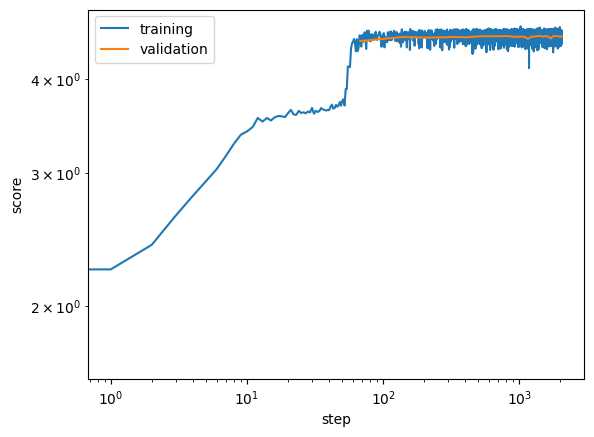

In [26]:

plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();

## Which folding state?

Each frame falls into one of states group
They are possibly transition region


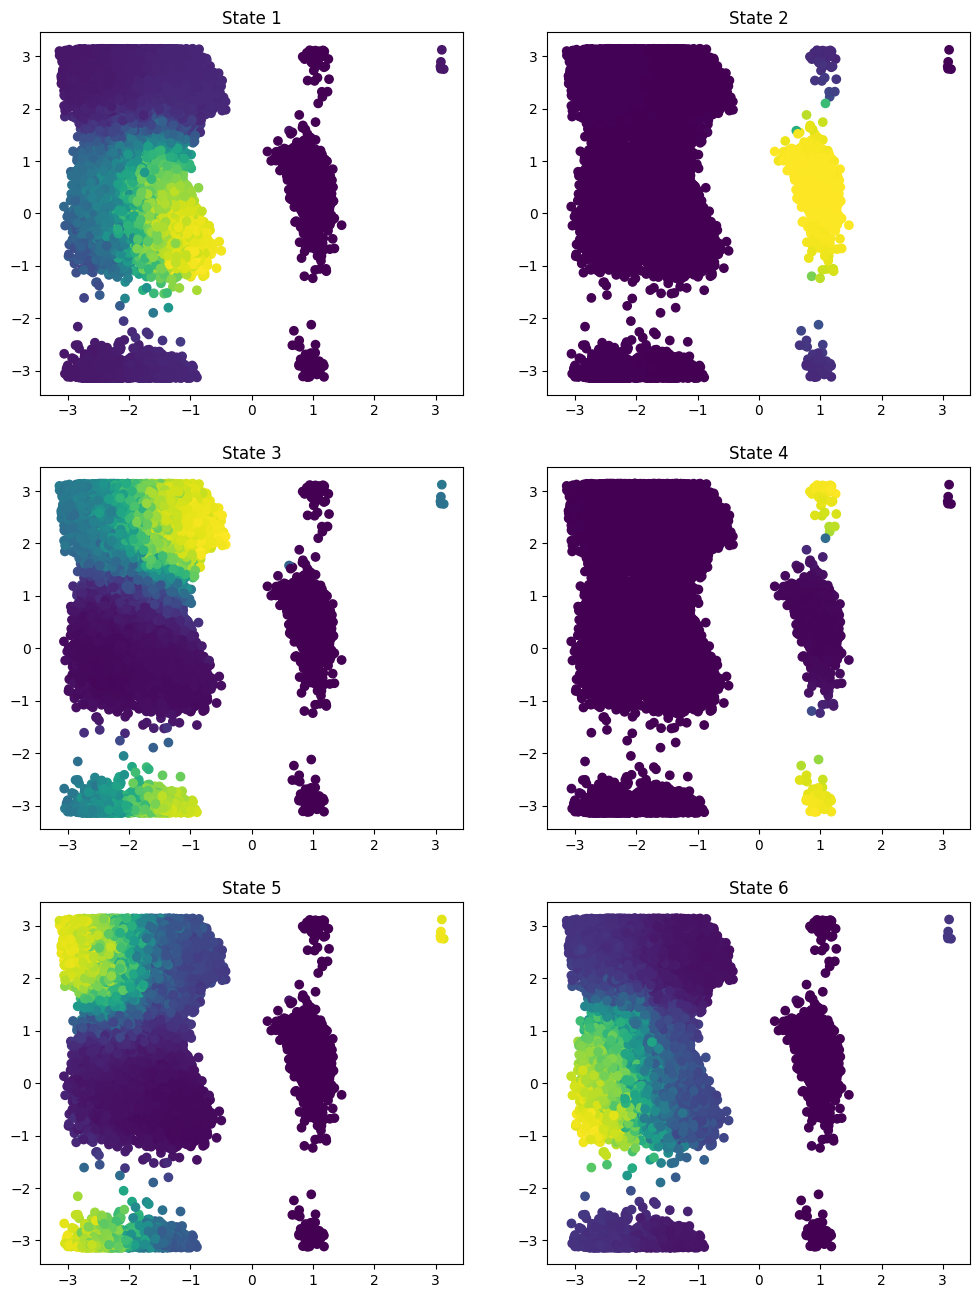

In [27]:
state_probabilities = model.transform(data[0])

f, axes = plt.subplots(3, 2, figsize=(12, 16))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(*dihedral[0][::5].T, c=state_probabilities[..., i][::5])
    ax.set_title(f'State {i+1}')

Yellow dots: On certain angle, a frame has high probability that it's in State i

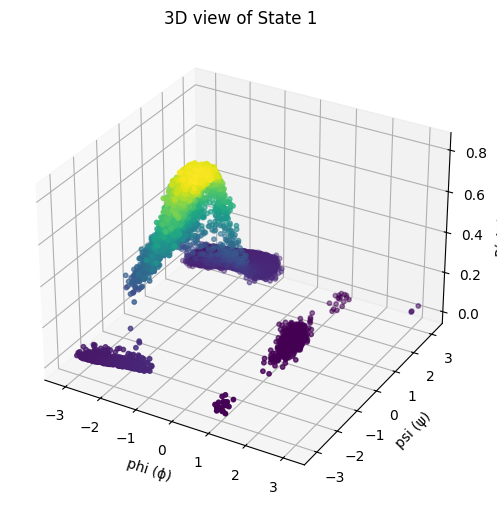

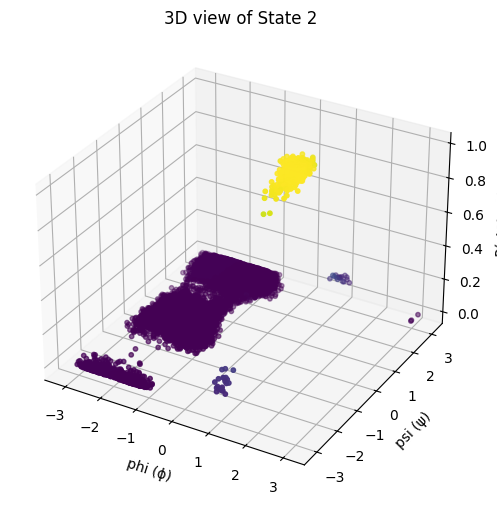

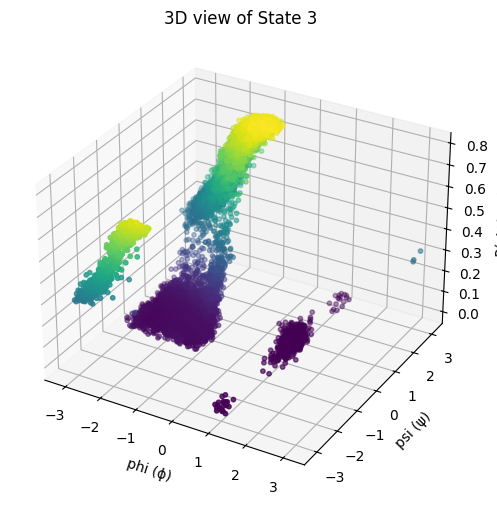

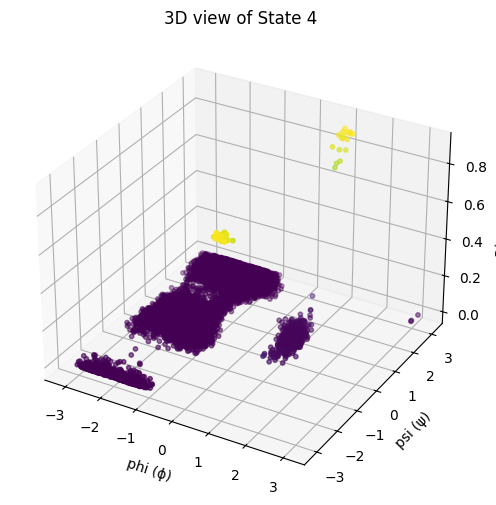

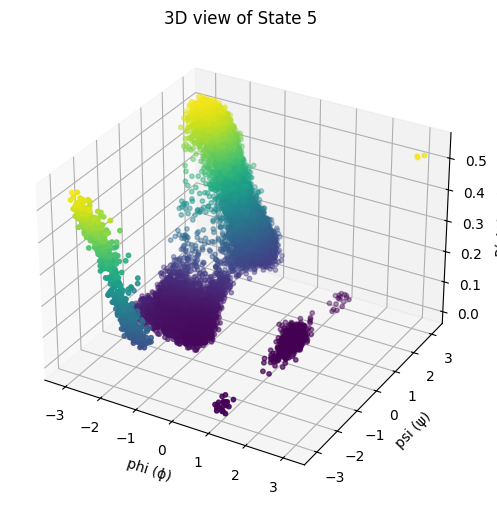

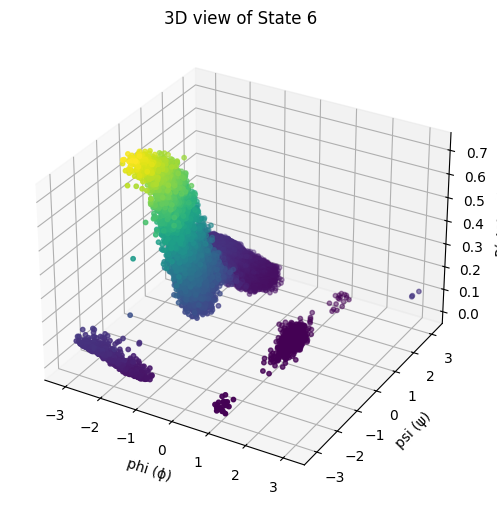

In [30]:
from mpl_toolkits.mplot3d import Axes3D

for i, ax in enumerate(axes.flatten()):
    phi, psi = dihedral[0].T  # φ, ψ 각도
    prob = state_probabilities[:, i]  # 특정 state i의 확률

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(phi[::10], psi[::10], prob[::10], c=prob[::10], cmap='viridis', s=10)
    ax.set_xlabel('phi (ϕ)')
    ax.set_ylabel('psi (ψ)')
    ax.set_zlabel(f'P(state {i+1})')
    plt.title(f'3D view of State {i+1}')
plt.show()
